In [1]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [2]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [3]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [5]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [6]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [7]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [8]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [9]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [10]:
print(training_data_Y[0].shape)

(200,)


In [11]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [12]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [13]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [14]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [15]:
import torch.utils.data

In [16]:
# Dataset Hyper Parameters
num_epochs = 20
batch_size = 100

In [17]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [237]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 25])
torch.Size([16])
torch.Size([8, 16, 25])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([32, 8])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


torch.Size([1775, 4])


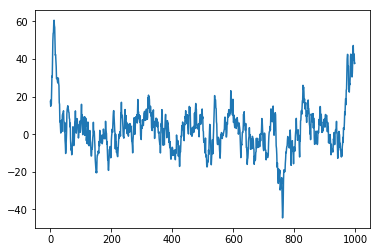

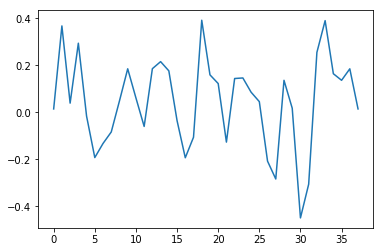

torch.Size([1775, 64])


In [221]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [1/17] Loss: [----- 1.7252 = 1.4217 + 1.00 * 0.0000 + 0.01 * 30.3491 -----]
Epoch [1/20], Iter [2/17] Loss: [----- 1.7789 = 1.4548 + 1.00 * 0.0207 + 0.01 * 30.3410 -----]
Epoch [1/20], Iter [3/17] Loss: [----- 1.7312 = 1.4063 + 1.00 * 0.0214 + 0.01 * 30.3421 -----]
Epoch [1/20], Iter [4/17] Loss: [----- 1.7256 = 1.4139 + 1.00 * 0.0082 + 0.01 * 30.3408 -----]
Epoch [1/20], Iter [5/17] Loss: [----- 1.7598 = 1.4396 + 1.00 * 0.0169 + 0.01 * 30.3392 -----]
Epoch [1/20], Iter [6/17] Loss: [----- 1.8105 = 1.4293 + 1.00 * 0.0777 + 0.01 * 30.3352 -----]
Epoch [1/20], Iter [7/17] Loss: [----- 1.9470 = 1.4042 + 1.00 * 0.2394 + 0.01 * 30.3322 -----]
Epoch [1/20], Iter [8/17] Loss: [----- 1.7280 = 1.3985 + 1.00 * 0.0261 + 0.01 * 30.3285 -----]
Epoch [1/20], Iter [9/17] Loss: [----- 2.0405 = 1.4513 + 1.00 * 0.2859 + 0.01 * 30.3253 -----]
Epoch [1/20], Iter [10/17] Loss: [----- 1.7953 = 1.4325 + 1.00 * 0.0596 + 0.01 * 30.3215 -----]
Epoch [1/20], Iter [11/17] Loss: [----- 1.8436 = 

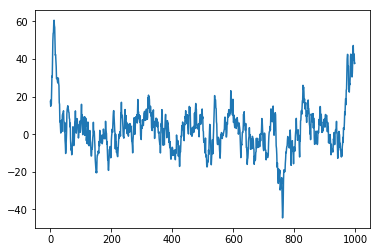

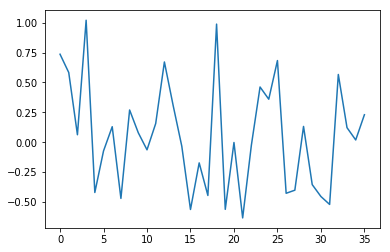

torch.Size([1775, 4])
Train Accuracy: 27 %


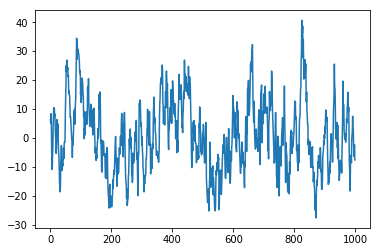

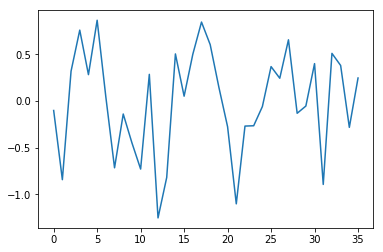

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [2/20], Iter [1/17] Loss: [----- 1.7482 = 1.3434 + 1.00 * 0.1020 + 0.01 * 30.2824 -----]
Epoch [2/20], Iter [2/17] Loss: [----- 2.3420 = 1.3992 + 1.00 * 0.6401 + 0.01 * 30.2766 -----]
Epoch [2/20], Iter [3/17] Loss: [----- 3.1892 = 1.3471 + 1.00 * 1.5394 + 0.01 * 30.2708 -----]
Epoch [2/20], Iter [4/17] Loss: [----- 2.1569 = 1.3569 + 1.00 * 0.4973 + 0.01 * 30.2648 -----]
Epoch [2/20], Iter [5/17] Loss: [----- 1.7067 = 1.3816 + 1.00 * 0.0224 + 0.01 * 30.2589 -----]
Epoch [2/20], Iter [6/17] Loss: [----- 2.4800 = 1.3796 + 1.00 * 0.7978 + 0.01 * 30.2527 -----]
Epoch [2/20], Iter [7/17] Loss: [----- 1.8131 = 1.3973 + 1.00 * 0.1133 + 0.01 * 30.2463 -----]
Epoch [2/20], Iter [8/17] Loss: [----- 1.7068 = 1.3778 + 1.00 * 0.0267 + 0.01 * 30.2405 -----]
Epoch [2/20], Iter [9/17] Loss: [----- 1.7831 = 1.3939 + 1.00 * 0.0869 + 0.01 * 30.2352 -----]
Epoch [2/20], Iter [10/17] Loss: [----- 1.7290 = 1.3900 + 1.00 * 0.0367 + 0

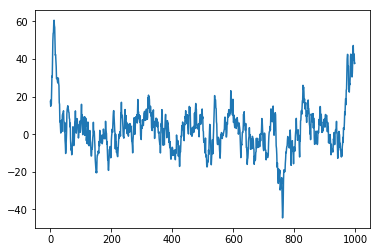

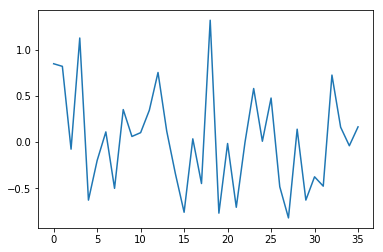

torch.Size([1775, 4])
Train Accuracy: 29 %


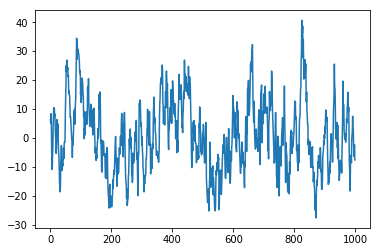

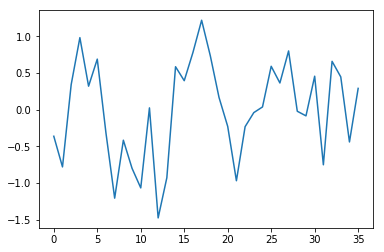

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [3/20], Iter [1/17] Loss: [----- 2.0789 = 1.3708 + 1.00 * 0.4063 + 0.01 * 30.1768 -----]
Epoch [3/20], Iter [2/17] Loss: [----- 1.7668 = 1.3620 + 1.00 * 0.1031 + 0.01 * 30.1703 -----]
Epoch [3/20], Iter [3/17] Loss: [----- 1.9017 = 1.3552 + 1.00 * 0.2449 + 0.01 * 30.1643 -----]
Epoch [3/20], Iter [4/17] Loss: [----- 1.9428 = 1.3851 + 1.00 * 0.2561 + 0.01 * 30.1590 -----]
Epoch [3/20], Iter [5/17] Loss: [----- 2.4473 = 1.3732 + 1.00 * 0.7725 + 0.01 * 30.1539 -----]
Epoch [3/20], Iter [6/17] Loss: [----- 1.7462 = 1.3794 + 1.00 * 0.0653 + 0.01 * 30.1485 -----]
Epoch [3/20], Iter [7/17] Loss: [----- 2.5824 = 1.3759 + 1.00 * 0.9050 + 0.01 * 30.1434 -----]
Epoch [3/20], Iter [8/17] Loss: [----- 2.4021 = 1.3622 + 1.00 * 0.7385 + 0.01 * 30.1379 -----]
Epoch [3/20], Iter [9/17] Loss: [----- 2.0368 = 1.3357 + 1.00 * 0.3998 + 0.01 * 30.1321 -----]
Epoch [3/20], Iter [10/17] Loss: [----- 2.5013 = 1.3868 + 1.00 * 0.8132 + 0

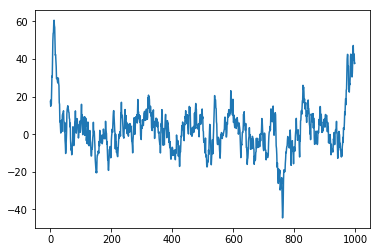

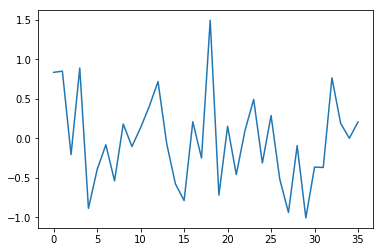

torch.Size([1775, 4])
Train Accuracy: 32 %


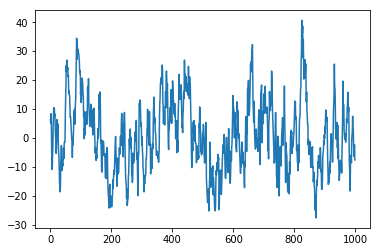

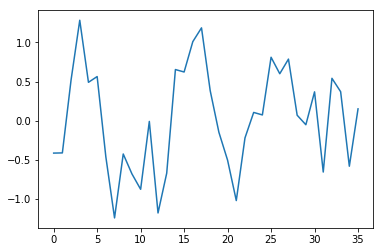

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [4/20], Iter [1/17] Loss: [----- 2.0729 = 1.3749 + 1.00 * 0.3973 + 0.01 * 30.0671 -----]
Epoch [4/20], Iter [2/17] Loss: [----- 1.8430 = 1.3380 + 1.00 * 0.2044 + 0.01 * 30.0608 -----]
Epoch [4/20], Iter [3/17] Loss: [----- 1.7722 = 1.3401 + 1.00 * 0.1315 + 0.01 * 30.0544 -----]
Epoch [4/20], Iter [4/17] Loss: [----- 1.8019 = 1.3388 + 1.00 * 0.1627 + 0.01 * 30.0483 -----]
Epoch [4/20], Iter [5/17] Loss: [----- 1.7345 = 1.3724 + 1.00 * 0.0616 + 0.01 * 30.0427 -----]
Epoch [4/20], Iter [6/17] Loss: [----- 1.7577 = 1.3615 + 1.00 * 0.0958 + 0.01 * 30.0373 -----]
Epoch [4/20], Iter [7/17] Loss: [----- 1.7559 = 1.3681 + 1.00 * 0.0874 + 0.01 * 30.0316 -----]
Epoch [4/20], Iter [8/17] Loss: [----- 1.7892 = 1.3657 + 1.00 * 0.1232 + 0.01 * 30.0260 -----]
Epoch [4/20], Iter [9/17] Loss: [----- 1.6961 = 1.3437 + 1.00 * 0.0522 + 0.01 * 30.0204 -----]
Epoch [4/20], Iter [10/17] Loss: [----- 1.8486 = 1.3438 + 1.00 * 0.2046 + 0

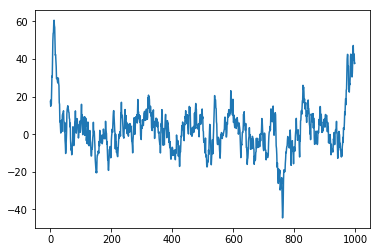

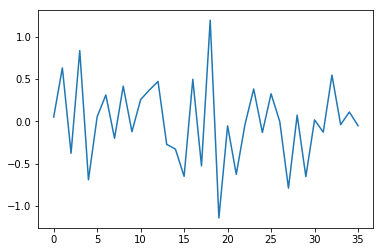

torch.Size([1775, 4])
Train Accuracy: 32 %


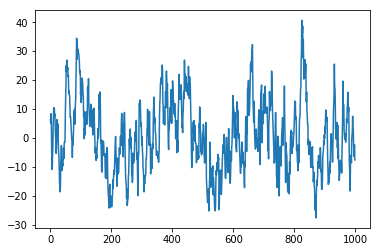

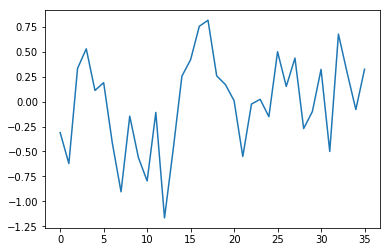

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [5/20], Iter [1/17] Loss: [----- 1.7691 = 1.3534 + 1.00 * 0.1161 + 0.01 * 29.9600 -----]
Epoch [5/20], Iter [2/17] Loss: [----- 1.6890 = 1.3692 + 1.00 * 0.0202 + 0.01 * 29.9538 -----]
Epoch [5/20], Iter [3/17] Loss: [----- 1.6846 = 1.3503 + 1.00 * 0.0348 + 0.01 * 29.9478 -----]
Epoch [5/20], Iter [4/17] Loss: [----- 1.6761 = 1.3480 + 1.00 * 0.0287 + 0.01 * 29.9423 -----]
Epoch [5/20], Iter [5/17] Loss: [----- 1.7860 = 1.3497 + 1.00 * 0.1369 + 0.01 * 29.9373 -----]
Epoch [5/20], Iter [6/17] Loss: [----- 1.7545 = 1.3317 + 1.00 * 0.1235 + 0.01 * 29.9320 -----]
Epoch [5/20], Iter [7/17] Loss: [----- 1.9920 = 1.3441 + 1.00 * 0.3486 + 0.01 * 29.9267 -----]
Epoch [5/20], Iter [8/17] Loss: [----- 1.6831 = 1.3278 + 1.00 * 0.0561 + 0.01 * 29.9215 -----]
Epoch [5/20], Iter [9/17] Loss: [----- 2.3529 = 1.3619 + 1.00 * 0.6918 + 0.01 * 29.9170 -----]
Epoch [5/20], Iter [10/17] Loss: [----- 1.7098 = 1.3538 + 1.00 * 0.0568 + 0

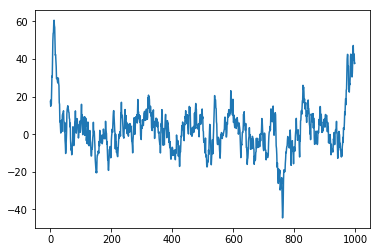

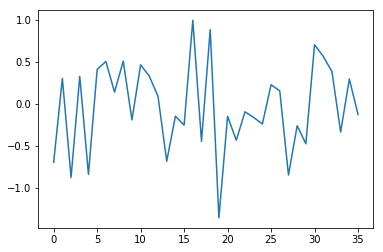

torch.Size([1775, 4])
Train Accuracy: 34 %


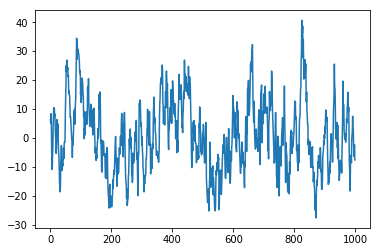

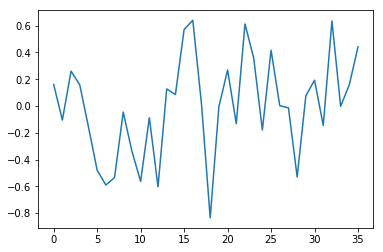

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [6/20], Iter [1/17] Loss: [----- 1.7018 = 1.3479 + 1.00 * 0.0552 + 0.01 * 29.8737 -----]
Epoch [6/20], Iter [2/17] Loss: [----- 1.8715 = 1.3369 + 1.00 * 0.2359 + 0.01 * 29.8696 -----]
Epoch [6/20], Iter [3/17] Loss: [----- 1.6588 = 1.3430 + 1.00 * 0.0171 + 0.01 * 29.8652 -----]
Epoch [6/20], Iter [4/17] Loss: [----- 3.8680 = 1.3419 + 1.00 * 2.2275 + 0.01 * 29.8613 -----]
Epoch [6/20], Iter [5/17] Loss: [----- 1.8064 = 1.3340 + 1.00 * 0.1739 + 0.01 * 29.8574 -----]
Epoch [6/20], Iter [6/17] Loss: [----- 2.7053 = 1.3816 + 1.00 * 1.0252 + 0.01 * 29.8541 -----]
Epoch [6/20], Iter [7/17] Loss: [----- 1.7088 = 1.3548 + 1.00 * 0.0555 + 0.01 * 29.8505 -----]
Epoch [6/20], Iter [8/17] Loss: [----- 2.1761 = 1.3230 + 1.00 * 0.5546 + 0.01 * 29.8470 -----]
Epoch [6/20], Iter [9/17] Loss: [----- 1.8348 = 1.3782 + 1.00 * 0.1581 + 0.01 * 29.8442 -----]
Epoch [6/20], Iter [10/17] Loss: [----- 1.6155 = 1.2970 + 1.00 * 0.0201 + 0

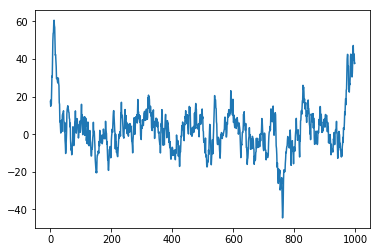

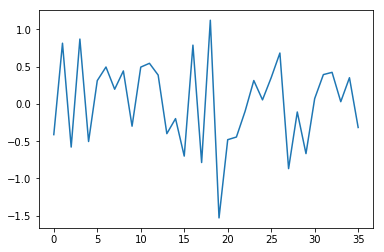

torch.Size([1775, 4])
Train Accuracy: 32 %


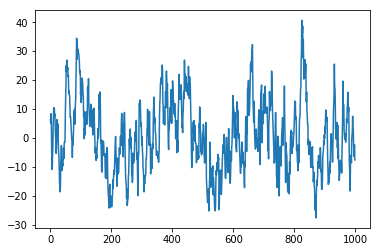

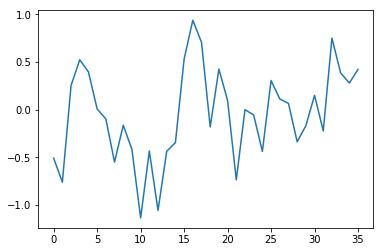

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [7/20], Iter [1/17] Loss: [----- 1.6770 = 1.3609 + 1.00 * 0.0180 + 0.01 * 29.8192 -----]
Epoch [7/20], Iter [2/17] Loss: [----- 2.2524 = 1.3627 + 1.00 * 0.5916 + 0.01 * 29.8162 -----]
Epoch [7/20], Iter [3/17] Loss: [----- 1.6068 = 1.3007 + 1.00 * 0.0080 + 0.01 * 29.8117 -----]
Epoch [7/20], Iter [4/17] Loss: [----- 2.1894 = 1.3244 + 1.00 * 0.5669 + 0.01 * 29.8074 -----]
Epoch [7/20], Iter [5/17] Loss: [----- 1.6589 = 1.3467 + 1.00 * 0.0141 + 0.01 * 29.8033 -----]
Epoch [7/20], Iter [6/17] Loss: [----- 1.6312 = 1.3222 + 1.00 * 0.0109 + 0.01 * 29.7993 -----]
Epoch [7/20], Iter [7/17] Loss: [----- 1.7004 = 1.3448 + 1.00 * 0.0576 + 0.01 * 29.7959 -----]
Epoch [7/20], Iter [8/17] Loss: [----- 1.7681 = 1.3754 + 1.00 * 0.0948 + 0.01 * 29.7925 -----]
Epoch [7/20], Iter [9/17] Loss: [----- 1.8684 = 1.2982 + 1.00 * 0.2724 + 0.01 * 29.7886 -----]
Epoch [7/20], Iter [10/17] Loss: [----- 2.4372 = 1.3118 + 1.00 * 0.8275 + 0

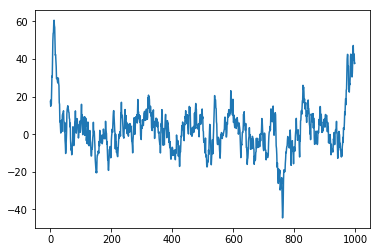

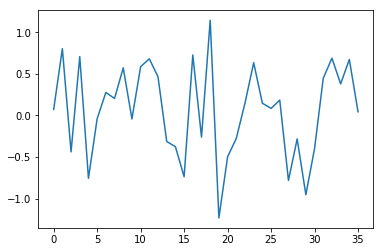

torch.Size([1775, 4])
Train Accuracy: 38 %


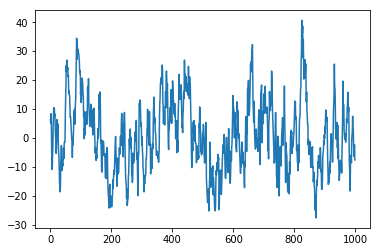

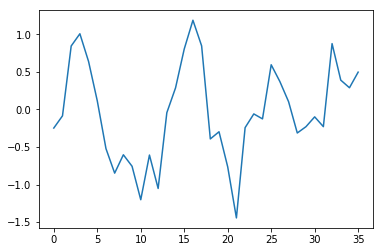

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [8/20], Iter [1/17] Loss: [----- 1.6341 = 1.3116 + 1.00 * 0.0249 + 0.01 * 29.7631 -----]
Epoch [8/20], Iter [2/17] Loss: [----- 1.6047 = 1.2899 + 1.00 * 0.0172 + 0.01 * 29.7618 -----]
Epoch [8/20], Iter [3/17] Loss: [----- 1.7546 = 1.2977 + 1.00 * 0.1593 + 0.01 * 29.7607 -----]
Epoch [8/20], Iter [4/17] Loss: [----- 1.5875 = 1.2880 + 1.00 * 0.0020 + 0.01 * 29.7597 -----]
Epoch [8/20], Iter [5/17] Loss: [----- 1.5931 = 1.2932 + 1.00 * 0.0022 + 0.01 * 29.7591 -----]
Epoch [8/20], Iter [6/17] Loss: [----- 1.6746 = 1.3172 + 1.00 * 0.0598 + 0.01 * 29.7586 -----]
Epoch [8/20], Iter [7/17] Loss: [----- 3.8451 = 1.3491 + 1.00 * 2.1984 + 0.01 * 29.7585 -----]
Epoch [8/20], Iter [8/17] Loss: [----- 2.0242 = 1.3128 + 1.00 * 0.4139 + 0.01 * 29.7583 -----]
Epoch [8/20], Iter [9/17] Loss: [----- 2.6667 = 1.3205 + 1.00 * 1.0486 + 0.01 * 29.7580 -----]
Epoch [8/20], Iter [10/17] Loss: [----- 1.6520 = 1.3353 + 1.00 * 0.0191 + 0

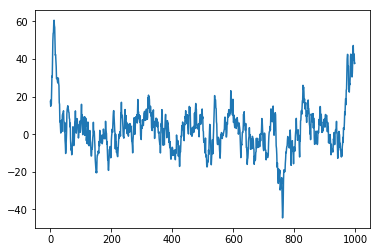

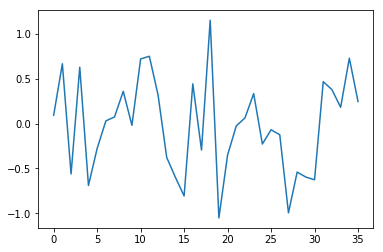

torch.Size([1775, 4])
Train Accuracy: 31 %


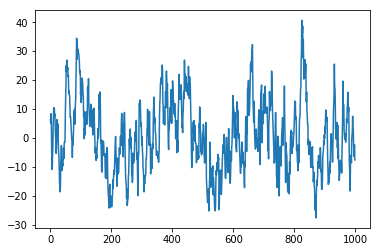

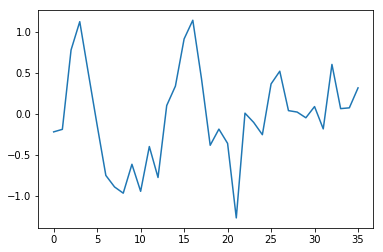

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [9/20], Iter [1/17] Loss: [----- 1.6374 = 1.2843 + 1.00 * 0.0556 + 0.01 * 29.7402 -----]
Epoch [9/20], Iter [2/17] Loss: [----- 1.7827 = 1.2421 + 1.00 * 0.2432 + 0.01 * 29.7392 -----]
Epoch [9/20], Iter [3/17] Loss: [----- 2.2100 = 1.3256 + 1.00 * 0.5870 + 0.01 * 29.7387 -----]
Epoch [9/20], Iter [4/17] Loss: [----- 1.6451 = 1.3052 + 1.00 * 0.0425 + 0.01 * 29.7389 -----]
Epoch [9/20], Iter [5/17] Loss: [----- 1.7545 = 1.3031 + 1.00 * 0.1541 + 0.01 * 29.7391 -----]
Epoch [9/20], Iter [6/17] Loss: [----- 1.6261 = 1.3096 + 1.00 * 0.0191 + 0.01 * 29.7394 -----]
Epoch [9/20], Iter [7/17] Loss: [----- 1.6619 = 1.3194 + 1.00 * 0.0451 + 0.01 * 29.7395 -----]
Epoch [9/20], Iter [8/17] Loss: [----- 1.6344 = 1.2734 + 1.00 * 0.0635 + 0.01 * 29.7393 -----]
Epoch [9/20], Iter [9/17] Loss: [----- 1.6053 = 1.3044 + 1.00 * 0.0035 + 0.01 * 29.7393 -----]
Epoch [9/20], Iter [10/17] Loss: [----- 2.3183 = 1.3775 + 1.00 * 0.6433 + 0

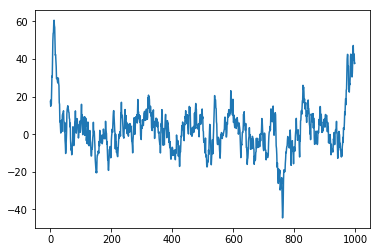

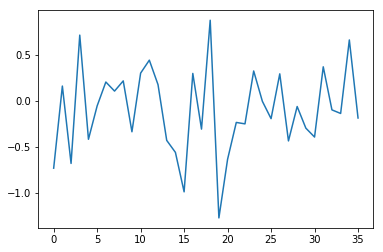

torch.Size([1775, 4])
Train Accuracy: 41 %


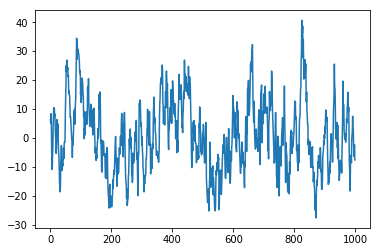

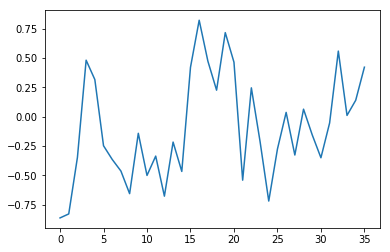

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 36 %
Epoch [10/20], Iter [1/17] Loss: [----- 1.6038 = 1.2858 + 1.00 * 0.0207 + 0.01 * 29.7315 -----]
Epoch [10/20], Iter [2/17] Loss: [----- 1.5354 = 1.2219 + 1.00 * 0.0162 + 0.01 * 29.7321 -----]
Epoch [10/20], Iter [3/17] Loss: [----- 2.0938 = 1.2474 + 1.00 * 0.5491 + 0.01 * 29.7333 -----]
Epoch [10/20], Iter [4/17] Loss: [----- 2.6140 = 1.2673 + 1.00 * 1.0493 + 0.01 * 29.7355 -----]
Epoch [10/20], Iter [5/17] Loss: [----- 1.7709 = 1.2338 + 1.00 * 0.2397 + 0.01 * 29.7382 -----]
Epoch [10/20], Iter [6/17] Loss: [----- 1.7352 = 1.2712 + 1.00 * 0.1666 + 0.01 * 29.7405 -----]
Epoch [10/20], Iter [7/17] Loss: [----- 1.5994 = 1.2782 + 1.00 * 0.0237 + 0.01 * 29.7425 -----]
Epoch [10/20], Iter [8/17] Loss: [----- 1.5676 = 1.2668 + 1.00 * 0.0033 + 0.01 * 29.7453 -----]
Epoch [10/20], Iter [9/17] Loss: [----- 2.6226 = 1.3175 + 1.00 * 1.0076 + 0.01 * 29.7480 -----]
Epoch [10/20], Iter [10/17] Loss: [----- 1.6019 = 1.2893 + 1.00 * 

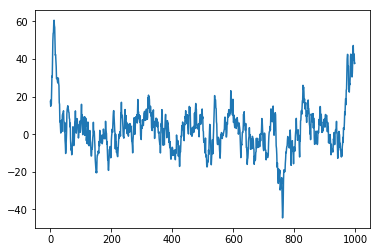

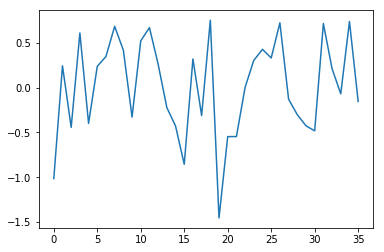

torch.Size([1775, 4])
Train Accuracy: 41 %


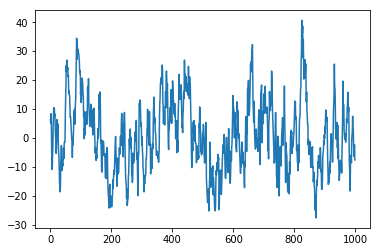

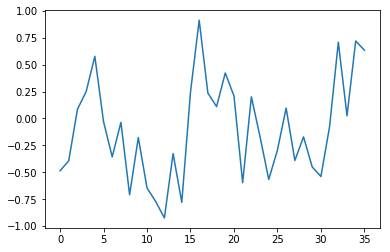

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [11/20], Iter [1/17] Loss: [----- 2.0116 = 1.3026 + 1.00 * 0.4115 + 0.01 * 29.7568 -----]
Epoch [11/20], Iter [2/17] Loss: [----- 1.6949 = 1.2255 + 1.00 * 0.1719 + 0.01 * 29.7564 -----]
Epoch [11/20], Iter [3/17] Loss: [----- 1.7726 = 1.2618 + 1.00 * 0.2133 + 0.01 * 29.7555 -----]
Epoch [11/20], Iter [4/17] Loss: [----- 1.6155 = 1.2875 + 1.00 * 0.0305 + 0.01 * 29.7554 -----]
Epoch [11/20], Iter [5/17] Loss: [----- 1.6237 = 1.2452 + 1.00 * 0.0809 + 0.01 * 29.7554 -----]
Epoch [11/20], Iter [6/17] Loss: [----- 1.6038 = 1.2904 + 1.00 * 0.0158 + 0.01 * 29.7562 -----]
Epoch [11/20], Iter [7/17] Loss: [----- 1.5648 = 1.2234 + 1.00 * 0.0439 + 0.01 * 29.7571 -----]
Epoch [11/20], Iter [8/17] Loss: [----- 1.5070 = 1.1832 + 1.00 * 0.0263 + 0.01 * 29.7584 -----]
Epoch [11/20], Iter [9/17] Loss: [----- 1.9761 = 1.2629 + 1.00 * 0.4157 + 0.01 * 29.7601 -----]
Epoch [11/20], Iter [10/17] Loss: [----- 1.7061 = 1.2302 + 1.00 * 

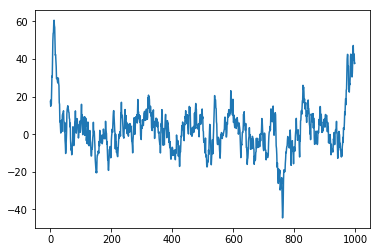

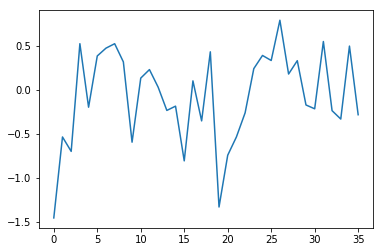

torch.Size([1775, 4])
Train Accuracy: 39 %


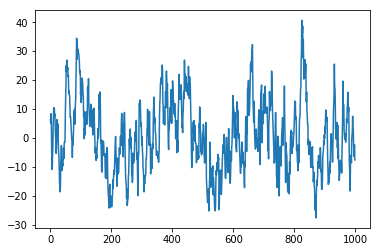

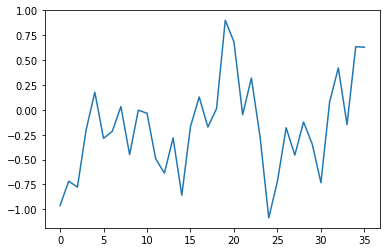

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [12/20], Iter [1/17] Loss: [----- 2.0021 = 1.2441 + 1.00 * 0.4603 + 0.01 * 29.7767 -----]
Epoch [12/20], Iter [2/17] Loss: [----- 1.6828 = 1.2102 + 1.00 * 0.1749 + 0.01 * 29.7780 -----]
Epoch [12/20], Iter [3/17] Loss: [----- 2.7593 = 1.2460 + 1.00 * 1.2155 + 0.01 * 29.7789 -----]
Epoch [12/20], Iter [4/17] Loss: [----- 1.5321 = 1.1903 + 1.00 * 0.0440 + 0.01 * 29.7800 -----]
Epoch [12/20], Iter [5/17] Loss: [----- 1.8325 = 1.3274 + 1.00 * 0.2073 + 0.01 * 29.7815 -----]
Epoch [12/20], Iter [6/17] Loss: [----- 1.8446 = 1.2685 + 1.00 * 0.2783 + 0.01 * 29.7833 -----]
Epoch [12/20], Iter [7/17] Loss: [----- 1.6040 = 1.2287 + 1.00 * 0.0774 + 0.01 * 29.7859 -----]
Epoch [12/20], Iter [8/17] Loss: [----- 1.6475 = 1.3322 + 1.00 * 0.0175 + 0.01 * 29.7887 -----]
Epoch [12/20], Iter [9/17] Loss: [----- 1.7907 = 1.2508 + 1.00 * 0.2420 + 0.01 * 29.7910 -----]
Epoch [12/20], Iter [10/17] Loss: [----- 1.6125 = 1.2633 + 1.00 * 

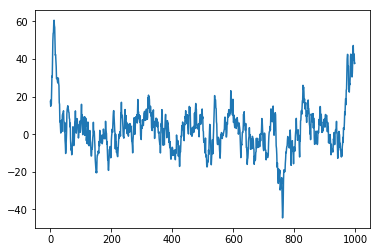

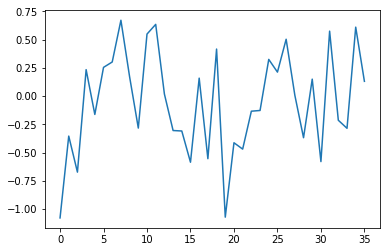

torch.Size([1775, 4])
Train Accuracy: 44 %


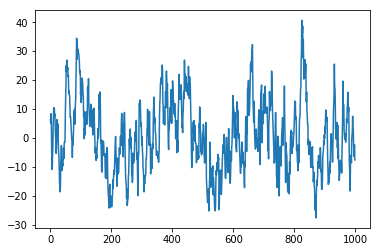

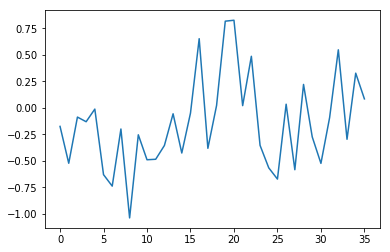

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 34 %
Epoch [13/20], Iter [1/17] Loss: [----- 2.0135 = 1.1931 + 1.00 * 0.5223 + 0.01 * 29.8059 -----]
Epoch [13/20], Iter [2/17] Loss: [----- 1.8405 = 1.1722 + 1.00 * 0.3702 + 0.01 * 29.8082 -----]
Epoch [13/20], Iter [3/17] Loss: [----- 1.6136 = 1.2336 + 1.00 * 0.0819 + 0.01 * 29.8106 -----]
Epoch [13/20], Iter [4/17] Loss: [----- 2.0710 = 1.3065 + 1.00 * 0.4663 + 0.01 * 29.8135 -----]
Epoch [13/20], Iter [5/17] Loss: [----- 1.5425 = 1.2390 + 1.00 * 0.0053 + 0.01 * 29.8164 -----]
Epoch [13/20], Iter [6/17] Loss: [----- 1.5115 = 1.2114 + 1.00 * 0.0020 + 0.01 * 29.8193 -----]
Epoch [13/20], Iter [7/17] Loss: [----- 2.3845 = 1.2558 + 1.00 * 0.8305 + 0.01 * 29.8227 -----]
Epoch [13/20], Iter [8/17] Loss: [----- 2.2907 = 1.2661 + 1.00 * 0.7264 + 0.01 * 29.8252 -----]
Epoch [13/20], Iter [9/17] Loss: [----- 1.5477 = 1.2114 + 1.00 * 0.0380 + 0.01 * 29.8275 -----]
Epoch [13/20], Iter [10/17] Loss: [----- 1.5430 = 1.2201 + 1.00 * 

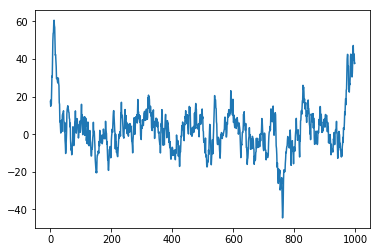

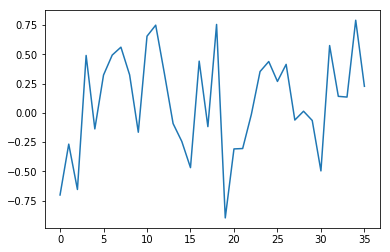

torch.Size([1775, 4])
Train Accuracy: 36 %


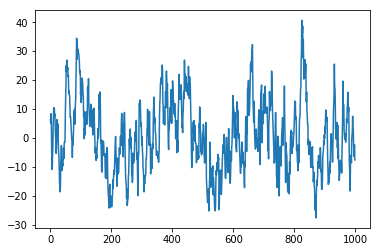

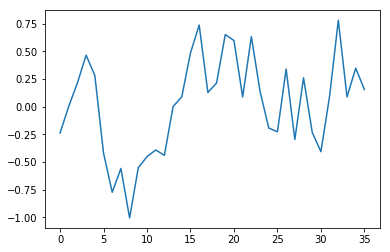

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [14/20], Iter [1/17] Loss: [----- 1.4645 = 1.1495 + 1.00 * 0.0165 + 0.01 * 29.8453 -----]
Epoch [14/20], Iter [2/17] Loss: [----- 2.1675 = 1.1942 + 1.00 * 0.6748 + 0.01 * 29.8471 -----]
Epoch [14/20], Iter [3/17] Loss: [----- 1.8166 = 1.2369 + 1.00 * 0.2812 + 0.01 * 29.8486 -----]
Epoch [14/20], Iter [4/17] Loss: [----- 2.2592 = 1.2502 + 1.00 * 0.7104 + 0.01 * 29.8513 -----]
Epoch [14/20], Iter [5/17] Loss: [----- 1.6335 = 1.2069 + 1.00 * 0.1281 + 0.01 * 29.8545 -----]
Epoch [14/20], Iter [6/17] Loss: [----- 1.6359 = 1.2505 + 1.00 * 0.0869 + 0.01 * 29.8572 -----]
Epoch [14/20], Iter [7/17] Loss: [----- 1.5140 = 1.1800 + 1.00 * 0.0354 + 0.01 * 29.8594 -----]
Epoch [14/20], Iter [8/17] Loss: [----- 1.7229 = 1.2686 + 1.00 * 0.1557 + 0.01 * 29.8621 -----]
Epoch [14/20], Iter [9/17] Loss: [----- 1.7237 = 1.2386 + 1.00 * 0.1865 + 0.01 * 29.8652 -----]
Epoch [14/20], Iter [10/17] Loss: [----- 1.9595 = 1.2031 + 1.00 * 

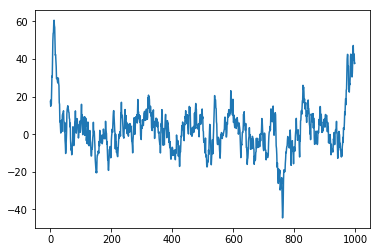

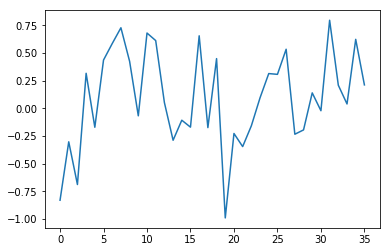

torch.Size([1775, 4])
Train Accuracy: 43 %


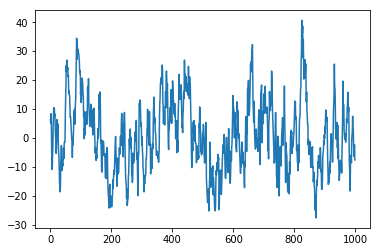

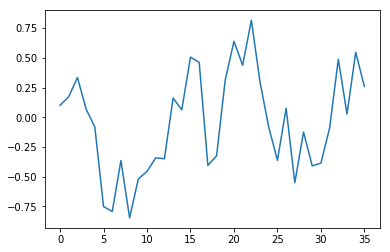

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [15/20], Iter [1/17] Loss: [----- 2.1082 = 1.1241 + 1.00 * 0.6852 + 0.01 * 29.8891 -----]
Epoch [15/20], Iter [2/17] Loss: [----- 3.3090 = 1.1918 + 1.00 * 1.8183 + 0.01 * 29.8912 -----]
Epoch [15/20], Iter [3/17] Loss: [----- 1.5062 = 1.1866 + 1.00 * 0.0207 + 0.01 * 29.8932 -----]
Epoch [15/20], Iter [4/17] Loss: [----- 1.8886 = 1.1515 + 1.00 * 0.4381 + 0.01 * 29.8958 -----]
Epoch [15/20], Iter [5/17] Loss: [----- 1.5146 = 1.1918 + 1.00 * 0.0239 + 0.01 * 29.8981 -----]
Epoch [15/20], Iter [6/17] Loss: [----- 1.7516 = 1.2460 + 1.00 * 0.2066 + 0.01 * 29.9001 -----]
Epoch [15/20], Iter [7/17] Loss: [----- 1.5768 = 1.2035 + 1.00 * 0.0743 + 0.01 * 29.9010 -----]
Epoch [15/20], Iter [8/17] Loss: [----- 1.9135 = 1.2038 + 1.00 * 0.4106 + 0.01 * 29.9017 -----]
Epoch [15/20], Iter [9/17] Loss: [----- 1.9288 = 1.1927 + 1.00 * 0.4371 + 0.01 * 29.9027 -----]
Epoch [15/20], Iter [10/17] Loss: [----- 1.6746 = 1.2347 + 1.00 * 

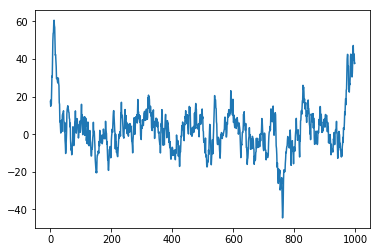

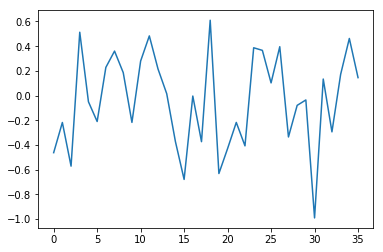

torch.Size([1775, 4])
Train Accuracy: 48 %


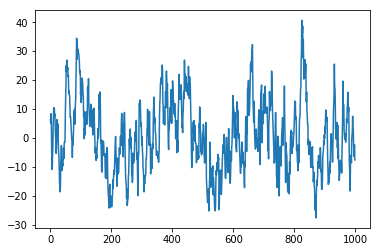

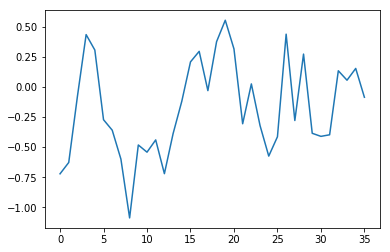

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 34 %
Epoch [16/20], Iter [1/17] Loss: [----- 2.3357 = 1.1661 + 1.00 * 0.8704 + 0.01 * 29.9226 -----]
Epoch [16/20], Iter [2/17] Loss: [----- 1.4260 = 1.1086 + 1.00 * 0.0182 + 0.01 * 29.9254 -----]
Epoch [16/20], Iter [3/17] Loss: [----- 2.9312 = 1.2238 + 1.00 * 1.4081 + 0.01 * 29.9283 -----]
Epoch [16/20], Iter [4/17] Loss: [----- 2.2552 = 1.2087 + 1.00 * 0.7472 + 0.01 * 29.9305 -----]
Epoch [16/20], Iter [5/17] Loss: [----- 2.3853 = 1.2156 + 1.00 * 0.8703 + 0.01 * 29.9327 -----]
Epoch [16/20], Iter [6/17] Loss: [----- 1.5214 = 1.2178 + 1.00 * 0.0043 + 0.01 * 29.9355 -----]
Epoch [16/20], Iter [7/17] Loss: [----- 1.7152 = 1.1932 + 1.00 * 0.2226 + 0.01 * 29.9379 -----]
Epoch [16/20], Iter [8/17] Loss: [----- 1.5130 = 1.1592 + 1.00 * 0.0544 + 0.01 * 29.9403 -----]
Epoch [16/20], Iter [9/17] Loss: [----- 1.6117 = 1.1700 + 1.00 * 0.1423 + 0.01 * 29.9431 -----]
Epoch [16/20], Iter [10/17] Loss: [----- 1.5663 = 1.2169 + 1.00 * 

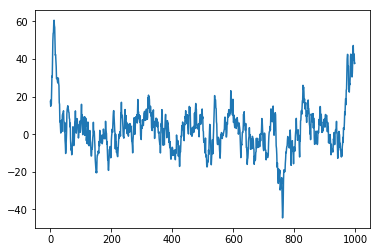

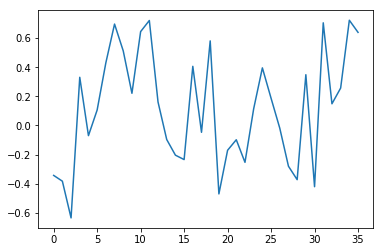

torch.Size([1775, 4])
Train Accuracy: 41 %


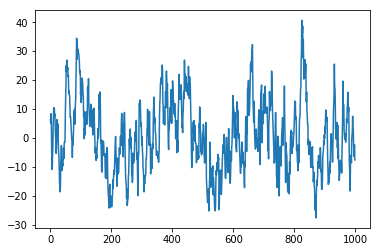

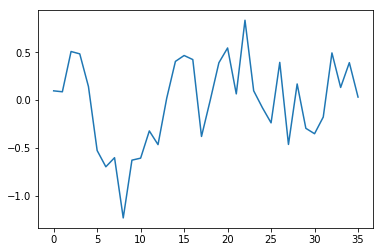

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [17/20], Iter [1/17] Loss: [----- 1.6117 = 1.2840 + 1.00 * 0.0280 + 0.01 * 29.9707 -----]
Epoch [17/20], Iter [2/17] Loss: [----- 4.8962 = 1.2619 + 1.00 * 3.3345 + 0.01 * 29.9722 -----]
Epoch [17/20], Iter [3/17] Loss: [----- 1.5430 = 1.1656 + 1.00 * 0.0777 + 0.01 * 29.9733 -----]
Epoch [17/20], Iter [4/17] Loss: [----- 1.9280 = 1.2937 + 1.00 * 0.3345 + 0.01 * 29.9740 -----]
Epoch [17/20], Iter [5/17] Loss: [----- 5.9770 = 1.1146 + 1.00 * 4.5627 + 0.01 * 29.9732 -----]
Epoch [17/20], Iter [6/17] Loss: [----- 1.7378 = 1.2239 + 1.00 * 0.2142 + 0.01 * 29.9739 -----]
Epoch [17/20], Iter [7/17] Loss: [----- 4.6378 = 1.1140 + 1.00 * 3.2241 + 0.01 * 29.9752 -----]
Epoch [17/20], Iter [8/17] Loss: [----- 1.8492 = 1.1496 + 1.00 * 0.3999 + 0.01 * 29.9760 -----]
Epoch [17/20], Iter [9/17] Loss: [----- 2.1364 = 1.2000 + 1.00 * 0.6366 + 0.01 * 29.9764 -----]
Epoch [17/20], Iter [10/17] Loss: [----- 2.2506 = 1.1738 + 1.00 * 

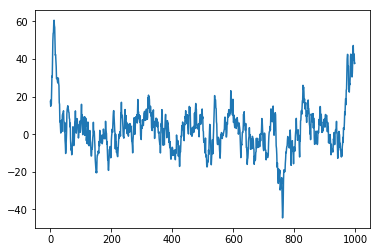

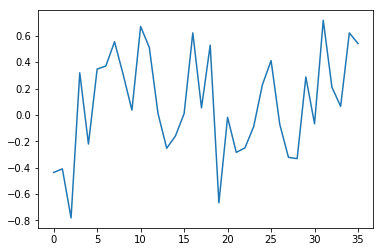

torch.Size([1775, 4])
Train Accuracy: 50 %


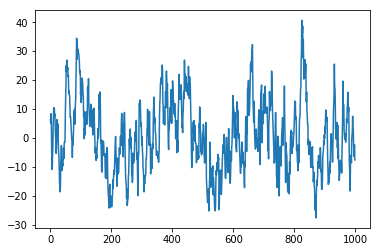

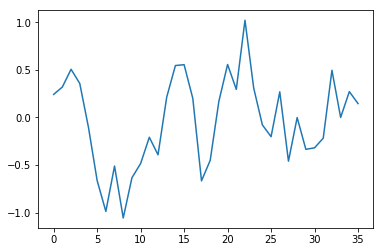

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 35 %
Epoch [18/20], Iter [1/17] Loss: [----- 3.7778 = 1.1516 + 1.00 * 2.3262 + 0.01 * 29.9912 -----]
Epoch [18/20], Iter [2/17] Loss: [----- 2.4113 = 1.1703 + 1.00 * 0.9410 + 0.01 * 29.9930 -----]
Epoch [18/20], Iter [3/17] Loss: [----- 1.9950 = 1.1920 + 1.00 * 0.5031 + 0.01 * 29.9952 -----]
Epoch [18/20], Iter [4/17] Loss: [----- 1.5389 = 1.1068 + 1.00 * 0.1322 + 0.01 * 29.9974 -----]
Epoch [18/20], Iter [5/17] Loss: [----- 2.6119 = 1.1292 + 1.00 * 1.1827 + 0.01 * 29.9997 -----]
Epoch [18/20], Iter [6/17] Loss: [----- 2.4545 = 1.1940 + 1.00 * 0.9605 + 0.01 * 30.0013 -----]
Epoch [18/20], Iter [7/17] Loss: [----- 1.5356 = 1.1479 + 1.00 * 0.0877 + 0.01 * 30.0035 -----]
Epoch [18/20], Iter [8/17] Loss: [----- 2.0935 = 1.0809 + 1.00 * 0.7125 + 0.01 * 30.0064 -----]
Epoch [18/20], Iter [9/17] Loss: [----- 1.9035 = 1.0478 + 1.00 * 0.5555 + 0.01 * 30.0099 -----]
Epoch [18/20], Iter [10/17] Loss: [----- 2.9821 = 1.1259 + 1.00 * 

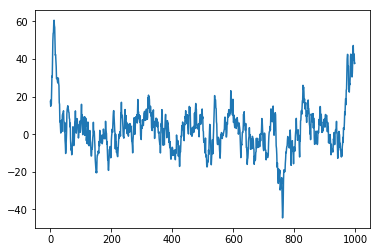

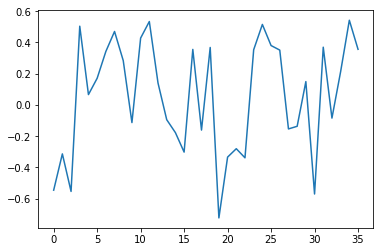

torch.Size([1775, 4])
Train Accuracy: 51 %


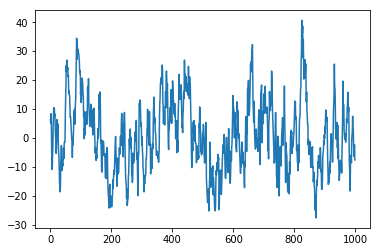

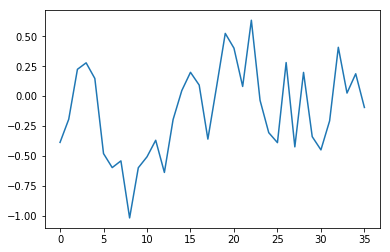

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 36 %
Epoch [19/20], Iter [1/17] Loss: [----- 1.9364 = 1.0732 + 1.00 * 0.5627 + 0.01 * 30.0491 -----]
Epoch [19/20], Iter [2/17] Loss: [----- 1.3671 = 1.0156 + 1.00 * 0.0509 + 0.01 * 30.0524 -----]
Epoch [19/20], Iter [3/17] Loss: [----- 2.4226 = 1.2161 + 1.00 * 0.9059 + 0.01 * 30.0566 -----]
Epoch [19/20], Iter [4/17] Loss: [----- 2.5280 = 1.1799 + 1.00 * 1.0475 + 0.01 * 30.0610 -----]
Epoch [19/20], Iter [5/17] Loss: [----- 1.9041 = 1.1556 + 1.00 * 0.4479 + 0.01 * 30.0651 -----]
Epoch [19/20], Iter [6/17] Loss: [----- 1.5057 = 1.1578 + 1.00 * 0.0473 + 0.01 * 30.0687 -----]
Epoch [19/20], Iter [7/17] Loss: [----- 1.5700 = 1.1273 + 1.00 * 0.1420 + 0.01 * 30.0715 -----]
Epoch [19/20], Iter [8/17] Loss: [----- 1.7588 = 1.1453 + 1.00 * 0.3127 + 0.01 * 30.0749 -----]
Epoch [19/20], Iter [9/17] Loss: [----- 1.8896 = 1.0802 + 1.00 * 0.5086 + 0.01 * 30.0780 -----]
Epoch [19/20], Iter [10/17] Loss: [----- 1.4109 = 1.0948 + 1.00 * 

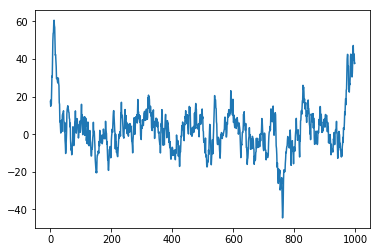

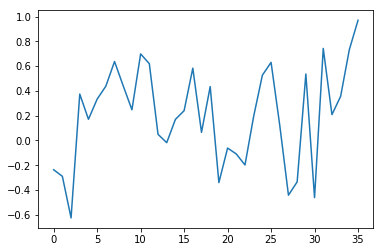

torch.Size([1775, 4])
Train Accuracy: 36 %


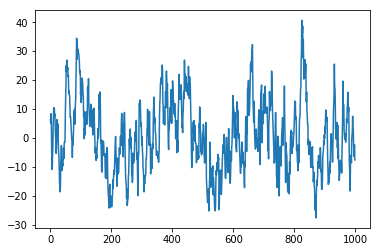

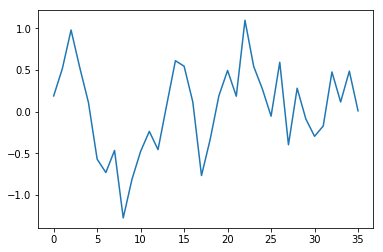

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 32 %
Epoch [20/20], Iter [1/17] Loss: [----- 1.8840 = 1.1598 + 1.00 * 0.4230 + 0.01 * 30.1120 -----]
Epoch [20/20], Iter [2/17] Loss: [----- 1.4666 = 1.0971 + 1.00 * 0.0683 + 0.01 * 30.1164 -----]
Epoch [20/20], Iter [3/17] Loss: [----- 2.9102 = 1.1971 + 1.00 * 1.4119 + 0.01 * 30.1215 -----]
Epoch [20/20], Iter [4/17] Loss: [----- 1.5480 = 1.1982 + 1.00 * 0.0485 + 0.01 * 30.1266 -----]
Epoch [20/20], Iter [5/17] Loss: [----- 1.4399 = 1.0644 + 1.00 * 0.0742 + 0.01 * 30.1312 -----]
Epoch [20/20], Iter [6/17] Loss: [----- 1.6845 = 1.1466 + 1.00 * 0.2366 + 0.01 * 30.1365 -----]
Epoch [20/20], Iter [7/17] Loss: [----- 2.8216 = 1.1033 + 1.00 * 1.4169 + 0.01 * 30.1416 -----]
Epoch [20/20], Iter [8/17] Loss: [----- 2.1982 = 1.2341 + 1.00 * 0.6627 + 0.01 * 30.1471 -----]
Epoch [20/20], Iter [9/17] Loss: [----- 3.6943 = 1.1805 + 1.00 * 2.2122 + 0.01 * 30.1519 -----]
Epoch [20/20], Iter [10/17] Loss: [----- 1.6012 = 1.1429 + 1.00 * 

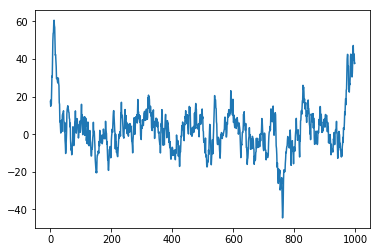

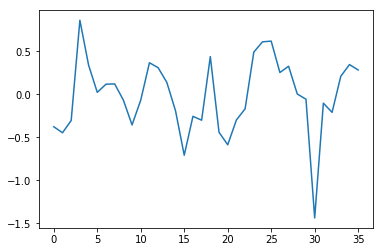

torch.Size([1775, 4])
Train Accuracy: 43 %


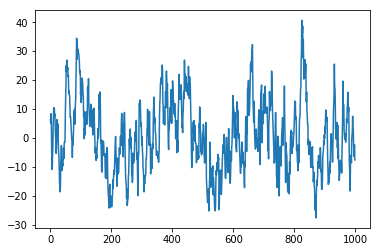

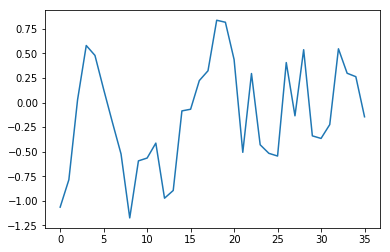

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 33 %


In [238]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 + reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

In [156]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)


 0.2320
 0.2928
 0.2867
 0.2776
 0.2940
 0.3093
 0.3722
 0.3570
 0.3030
 0.2924
 0.2994
 0.3299
 0.3383
 0.3730
 0.3764
 0.3794
 0.3260
 0.3303
 0.3158
 0.3569
 0.3735
 0.3406
[torch.FloatTensor of size (22,)]


 128.5609
 106.0961
 120.2741
 132.9721
 126.8234
 119.8886
  77.5029
 102.5849
 115.4050
 129.3320
 121.3680
 119.7015
 103.3743
 108.4402
 114.3926
 124.2197
 122.0159
 124.4923
 118.3511
 128.1105
 126.3401
 130.9359
[torch.FloatTensor of size (22,)]

